<a href="https://colab.research.google.com/github/dineshkumar-2003/Datascience-practice/blob/main/Object_classification_in_single_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from torchvision import datasets
import os

class CleanedImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        # Override to skip .ipynb_checkpoints
        classes = sorted(
            entry.name for entry in os.scandir(directory)
            if entry.is_dir() and entry.name != ".ipynb_checkpoints"
        )
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx


In [34]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets

# === CONFIG ===
DATASET_PATH = "/content/drive/MyDrive/object classification dataset"
CLASS_NAMES = ["cat", "dog", "laptop", "person"]
NUM_CLASSES = len(CLASS_NAMES)
BATCH_SIZE = 16
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORM ===
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# === FILE FILTER (exclude .ipynb_checkpoints and invalid files) ===
def is_valid_file(path):
    return (not ".ipynb_checkpoints" in path) and path.lower().endswith((".jpg", ".jpeg", ".png"))

# === CUSTOM DATASET ===
class MultiLabelDataset(CleanedImageFolder):
    def __getitem__(self, index):
        path, class_idx = self.samples[index]
        img = self.loader(path)
        img = transform(img)
        label_name = self.classes[class_idx]
        label = torch.tensor([1 if c == label_name else 0 for c in CLASS_NAMES], dtype=torch.float32)
        return img, label


# === LOAD DATA ===
dataset = MultiLabelDataset(DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# === MODEL ===
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, NUM_CLASSES),
    nn.Sigmoid()  # multi-label output
)
model = model.to(DEVICE)

# === LOSS & OPTIMIZER ===
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === TRAINING ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch+1}/{EPOCHS}] Loss: {total_loss / len(dataloader):.4f}")


[Epoch 1/20] Loss: 0.3654
[Epoch 2/20] Loss: 0.4769
[Epoch 3/20] Loss: 0.3288
[Epoch 4/20] Loss: 0.2896
[Epoch 5/20] Loss: 0.2651
[Epoch 6/20] Loss: 0.2963
[Epoch 7/20] Loss: 0.3084
[Epoch 8/20] Loss: 0.2559
[Epoch 9/20] Loss: 0.2529
[Epoch 10/20] Loss: 0.3329
[Epoch 11/20] Loss: 0.2494
[Epoch 12/20] Loss: 0.1838
[Epoch 13/20] Loss: 0.1570
[Epoch 14/20] Loss: 0.2026
[Epoch 15/20] Loss: 0.2513
[Epoch 16/20] Loss: 0.2515
[Epoch 17/20] Loss: 0.2552
[Epoch 18/20] Loss: 0.2470
[Epoch 19/20] Loss: 0.1943
[Epoch 20/20] Loss: 0.2398


In [35]:
!pip install grad-cam

Predicted: ['laptop']


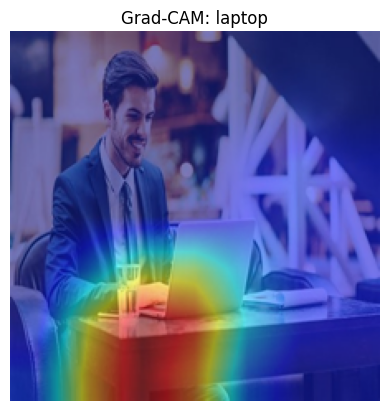

In [50]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# === Load test image ===
img_path = "/content/drive/MyDrive/test images for multi object detection/OIP (2).jpg"  # <-- replace with your actual image path
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(DEVICE)

# === Get prediction ===
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    predicted_classes = [CLASS_NAMES[i] for i in range(NUM_CLASSES) if output[0][i] > 0.3]
    print("Predicted:", predicted_classes)

# === Grad-CAM Setup ===
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)


# Convert image to numpy format for visualization
rgb_img = np.array(img.resize((224, 224))).astype(np.float32) / 255.0

# === Generate heatmap for each predicted class ===
# for class_idx, class_name in enumerate(CLASS_NAMES):
#     if output[0][class_idx] > 0.5:
#         grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(class_idx)])
#         grayscale_cam = grayscale_cam[0]
#         cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

#         plt.imshow(cam_image)
#         plt.title(f"Detected: {class_name}")
#         plt.axis("off")
#         plt.show()

# Remove the confidence check
for class_idx, class_name in enumerate(CLASS_NAMES):
    if output[0][class_idx] > 0.3:
      grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(class_idx)])
      grayscale_cam = grayscale_cam[0]
      cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

      plt.imshow(cam_image)
      plt.title(f"Grad-CAM: {class_name}")
      plt.axis("off")
      plt.show()



Patch 1 Predictions: [('dog', 0.9194453954696655)]


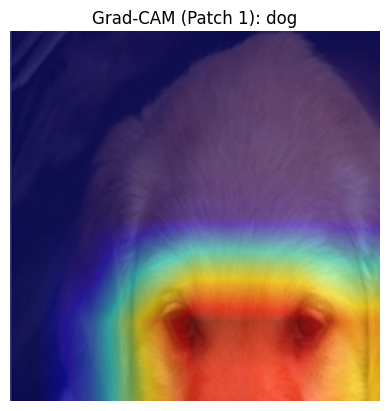

Patch 2 Predictions: []
Patch 3 Predictions: [('dog', 0.5025960803031921)]
Patch 4 Predictions: [('cat', 0.9979339838027954)]


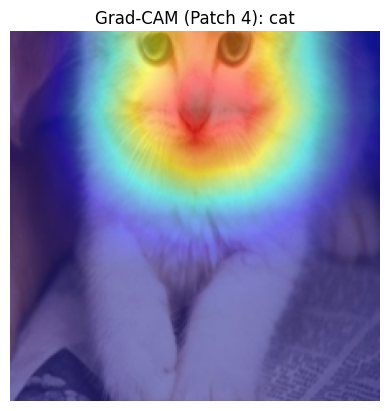

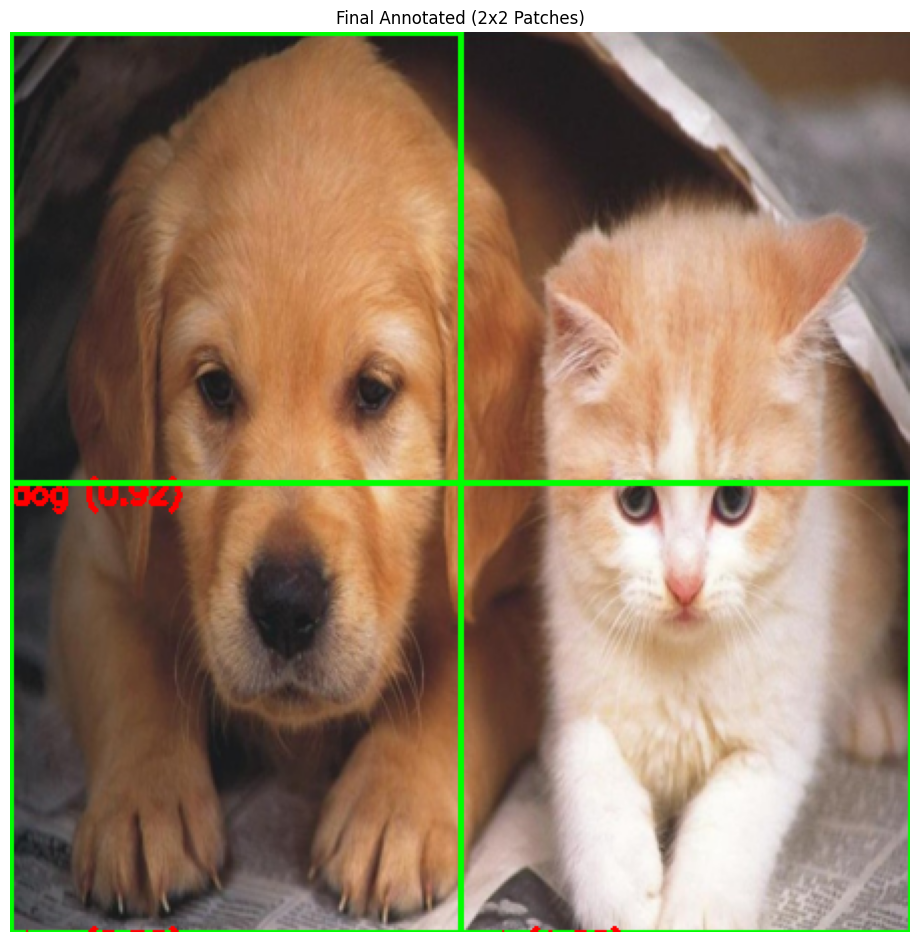

In [89]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# === Set model to eval mode before inference ===
model.eval()

# === Test-time transform (no randomness) ===
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === Load test image ===
img_path = "/content/drive/MyDrive/test images for multi object detection/R.jpg"
img = Image.open(img_path).convert("RGB")

# Resize original image for consistent 2x2 patch split
original_img_rgb = np.array(img.resize((224 * 2, 224 * 2)))
h, w, _ = original_img_rgb.shape
grid_h, grid_w = h // 2, w // 2

patches = []
coords = []

for row in range(2):
    for col in range(2):
        y1, y2 = row * grid_h, (row + 1) * grid_h
        x1, x2 = col * grid_w, (col + 1) * grid_w
        cropped = original_img_rgb[y1:y2, x1:x2]
        cropped_pil = Image.fromarray(cropped).resize((224, 224))
        cropped_tensor = test_transform(cropped_pil).unsqueeze(0).to(DEVICE)
        patches.append((cropped_tensor, cropped_pil))
        coords.append((x1, y1, x2, y2))

annotated_img = original_img_rgb.copy()

# Optional: Grad-CAM setup
cam = GradCAM(model=model, target_layers=[model.layer4[-1]])

# === Run prediction on each patch ===
for i, ((tensor, pil_img), (x1, y1, x2, y2)) in enumerate(zip(patches, coords)):
    with torch.no_grad():
        output = model(tensor)[0]
        predicted = [(CLASS_NAMES[i], float(output[i])) for i in range(NUM_CLASSES) if output[i] > 0.5]
        print(f"Patch {i+1} Predictions:", predicted)

    if predicted:
        label_text = ", ".join(f"{cls} ({conf:.2f})" for cls, conf in predicted)
        import cv2
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated_img, label_text, (x1, y2 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Grad-CAM visualization for confident predictions
        for class_idx, class_name in enumerate(CLASS_NAMES):
            if output[class_idx] > 0.7:  # stricter confidence for CAM
                grayscale_cam = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(class_idx)])[0]
                cropped_np = np.array(pil_img).astype(np.float32) / 255.0
                cam_image = show_cam_on_image(cropped_np, grayscale_cam, use_rgb=True)
                plt.imshow(cam_image)
                plt.title(f"Grad-CAM (Patch {i+1}): {class_name}")
                plt.axis("off")
                plt.show()

# === Show Final Annotated Image ===
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.05, right=0.95, bottom=2.05, top=2.95)
plt.imshow(annotated_img)
plt.title("Final Annotated (2x2 Patches)")
plt.axis("off")
plt.show()
